# Inspecting Poisson-Gauss.nc and Wave-C-Sines.nc

This notebook shows small samples from two NetCDF datasets used in GAOT. Files store fields as arrays with axes `[batch, time, space, variables]` (see `datasets/README.md`). In this repo:
- **Poisson-Gauss** is an elliptic PDE dataset with solution `u` and forcing/source `f`.
- **Wave-C-Sines** is a hyperbolic PDE dataset with time-varying solution `u` and no `c` group.


In [1]:
%matplotlib inline
from pathlib import Path

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

DATA_ROOT = Path("datasets")
POISSON_PATH = DATA_ROOT / "time_indep" / "Poisson-Gauss.nc"
WAVE_PATH = DATA_ROOT / "time_dep" / "Wave-C-Sines.nc"

print("Poisson-Gauss exists:", POISSON_PATH.exists())
print("Wave-C-Sines exists:", WAVE_PATH.exists())


Poisson-Gauss exists: True
Wave-C-Sines exists: True


In [2]:
def open_groups(path, groups=("u", "c", "x")):
    # Open known NetCDF groups if present; fallback to root dataset.
    opened = {}
    for group in groups:
        try:
            opened[group] = xr.open_dataset(path, group=group)
        except Exception:
            continue
    if not opened:
        opened["root"] = xr.open_dataset(path)
    return opened


def first_var(ds):
    # Return the first data variable in a dataset (NetCDF group).
    return ds[list(ds.data_vars)[0]]


def describe_groups(label, groups):
    print(f"== {label} ==")
    for name, ds in groups.items():
        print(f"[{name}] variables: {list(ds.data_vars)}")
        for var in ds.data_vars:
            print(f"  - {var}: shape={ds[var].shape}, dims={ds[var].dims}")


def select_bt(arr, batch=0, time=0):
    # Select a single batch/time slice; returns [space, vars] or [space, dims].
    a = np.asarray(arr)
    if a.ndim == 4:
        return a[batch, time]
    if a.ndim == 3:
        return a[batch]
    if a.ndim == 2:
        return a
    raise ValueError(f"Unexpected array shape: {a.shape}")


def scalar_field(sample, var=0):
    a = np.asarray(sample)
    if a.ndim == 2:
        return a[:, var]
    if a.ndim == 1:
        return a
    raise ValueError(f"Unexpected field shape: {a.shape}")


def plot_scalar_field(xy, field, title, ax=None, max_points=4000):
    a = np.asarray(xy)
    f = np.asarray(field)
    n = len(f)
    if n > max_points:
        idx = np.random.choice(n, size=max_points, replace=False)
        a = a[idx]
        f = f[idx]

    if ax is None:
        ax = plt.gca()

    if a.shape[1] >= 2:
        sc = ax.scatter(a[:, 0], a[:, 1], c=f, s=6, cmap="viridis")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        plt.colorbar(sc, ax=ax, shrink=0.8)
    else:
        ax.plot(a[:, 0], f, ".", markersize=3)
        ax.set_xlabel("x")
        ax.set_ylabel("u")

    ax.set_title(title)
    ax.set_aspect("equal", adjustable="box")


## Poisson-Gauss (elliptic PDE)

This dataset corresponds to a Poisson equation where the solution `u` is driven by a source term `f` (stored as group `c`). A common form is `-Delta u = f` on a 2D domain with boundary conditions. We'll visualize one sample's source and solution on the mesh points `x`.


== Poisson-Gauss ==
[root] variables: ['c', 'u', 'x']
  - c: shape=(3000, 1, 16384, 1), dims=('phony_dim_0', 'phony_dim_1', 'phony_dim_2', 'phony_dim_3')
  - u: shape=(3000, 1, 16384, 1), dims=('phony_dim_0', 'phony_dim_1', 'phony_dim_2', 'phony_dim_3')
  - x: shape=(1, 1, 16384, 2), dims=('phony_dim_1', 'phony_dim_3', 'phony_dim_2', 'phony_dim_4')


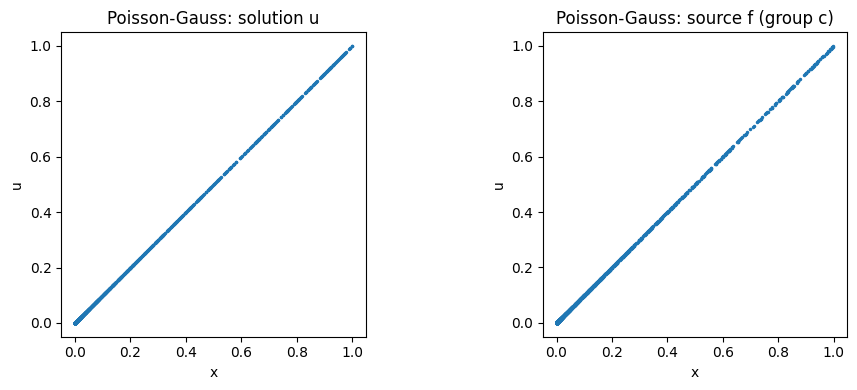

In [5]:
poisson_groups = open_groups(POISSON_PATH)
describe_groups("Poisson-Gauss", poisson_groups)

u_ds = poisson_groups.get("u", poisson_groups.get("root"))
c_ds = poisson_groups.get("c", poisson_groups.get("root"))
x_ds = poisson_groups.get("x", poisson_groups.get("root"))

u = first_var(u_ds)
x = first_var(x_ds)

u_sample = select_bt(u, batch=0, time=0)
x_sample = select_bt(x, batch=0, time=0)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_scalar_field(x_sample, scalar_field(u_sample), "Poisson-Gauss: solution u", ax=axes[0])

if c_ds is not None:
    c = first_var(c_ds)
    c_sample = select_bt(c, batch=0, time=0)
    plot_scalar_field(x_sample, scalar_field(c_sample), "Poisson-Gauss: source f (group c)", ax=axes[1])
else:
    axes[1].axis("off")
    axes[1].set_title("No c group found")

plt.tight_layout()
plt.show()


## Wave-C-Sines (hyperbolic PDE)

This dataset corresponds to a wave equation with time evolution (e.g., `u_tt = c^2 Delta u`). The file stores `u(x, t)` across multiple time steps; there is no `c` group in this dataset. We'll visualize a few time snapshots for a single batch.


== Wave-C-Sines ==
[root] variables: ['u', 'x']
  - u: shape=(1500, 21, 16431, 1), dims=('phony_dim_0', 'phony_dim_1', 'phony_dim_2', 'phony_dim_3')
  - x: shape=(1, 1, 16431, 2), dims=('phony_dim_3', 'phony_dim_4', 'phony_dim_2', 'phony_dim_5')


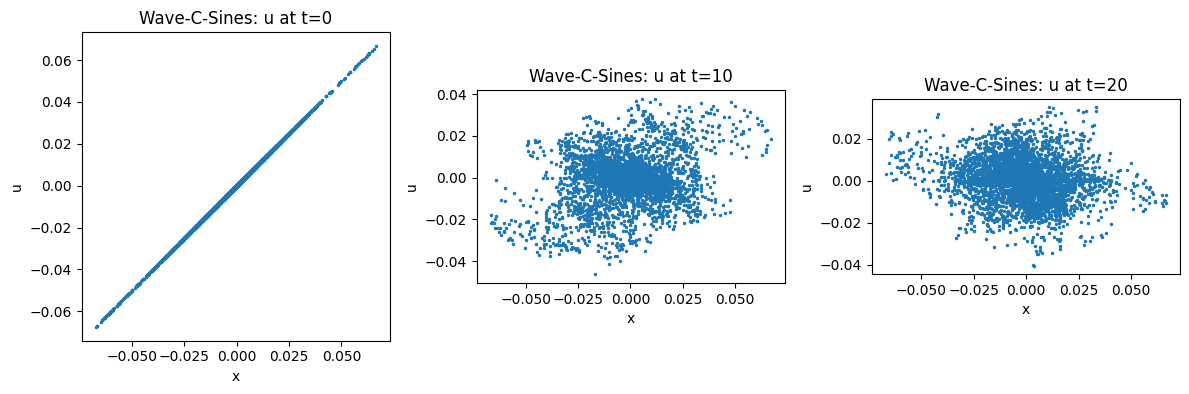

In [4]:
wave_groups = open_groups(WAVE_PATH)
describe_groups("Wave-C-Sines", wave_groups)

u_ds = wave_groups.get("u", wave_groups.get("root"))
x_ds = wave_groups.get("x", wave_groups.get("root"))

u = first_var(u_ds)
x = first_var(x_ds)

u_arr = np.asarray(u)
if u_arr.ndim == 4:
    n_time = u_arr.shape[1]
    time_indices = [0, n_time // 2, n_time - 1]
else:
    n_time = 1
    time_indices = [0]

x_sample = select_bt(x, batch=0, time=0)

fig, axes = plt.subplots(1, len(time_indices), figsize=(4 * len(time_indices), 4))
if len(time_indices) == 1:
    axes = [axes]

for ax, t_idx in zip(axes, time_indices):
    u_sample = select_bt(u, batch=0, time=t_idx)
    plot_scalar_field(x_sample, scalar_field(u_sample), f"Wave-C-Sines: u at t={t_idx}", ax=ax)

plt.tight_layout()
plt.show()
